# Testing Waveform Utilities & Autoencoder Dataset

This notebook will visually verify:

1. **Waveform reduction** (`reducir_onda`)
2. **Reading single emissions** (`leer_emision`)
3. **Concatenating one sample** (`ondas_probeta`)
4. **Loading all waves** (`leer_ondas`, `leer_probetas`)
5. **`DatasetAutoencoder`** behavior and plotting

In [1]:
import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path().resolve().parent
sys.path.append(str(project_root))

import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from common.waveforms import reduce_waveform, load_emission_waveforms, load_sample_waveforms, load_all_waveforms, load_waveforms_by_sample
from models.autoencoder.dataset import DatasetAutoencoder
from common.config import WAVES_DIR

config.py: DEVICE is set as cpu


## `reduce_waveform()`
Generate a noisy sine wave of length 1000, then apply each reduction mode with `reduce_waveform`:
- **none**: center only  
- **resample**: FFT‐based down to n points  
- **mean**: windowed average  
- **max**: windowed max‐deviation  

You may modes to modify the reduction parameter.

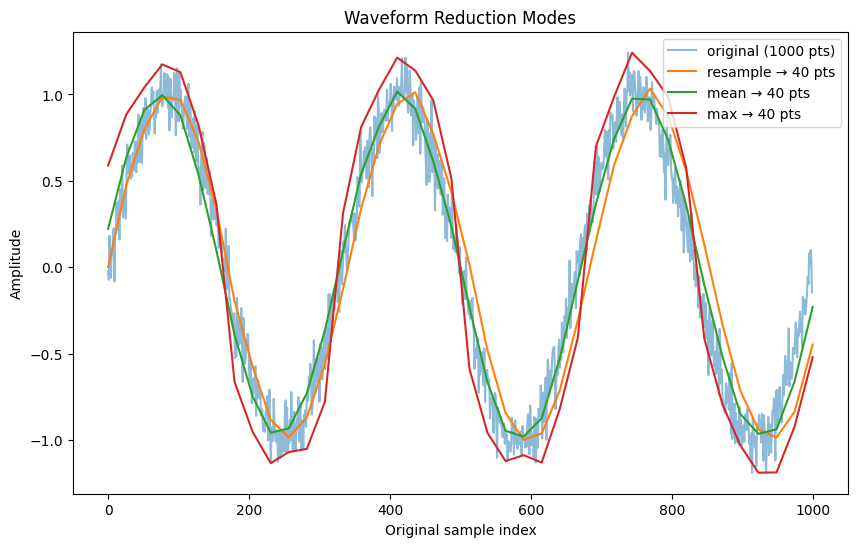

In [2]:
t = torch.linspace(0, 2*np.pi, steps=1000)
wave = torch.sin(3*t) + 0.1*torch.randn_like(t)

modes = [("", 0), ("resample", 40), ("mean", 25), ("max", 25)] # TRY CHANGING THIS
plt.figure(figsize=(10, 6))
plt.plot(wave.numpy(), label="original (1000 pts)", alpha=0.5)

for mode, n in modes[1:]:
    reduced = reduce_waveform(wave, modo=mode, n=n)
    plt.plot(
        np.linspace(0, len(wave), len(reduced)),
        reduced.cpu().numpy(),
        label=f"{mode} → {len(reduced)} pts"
    )

plt.title("Waveform Reduction Modes")
plt.legend()
plt.xlabel("Original sample index")
plt.ylabel("Amplitude")
plt.show()


## `leer_emision()`
Pick one `PL*.txt` file from sample “00”, reduce each of its 11 waveforms, and plot them. You can experiment changing the reduction parameter. The plot is of the waves received by the 11 sensors, emitted by the first emitter on the wall 00.


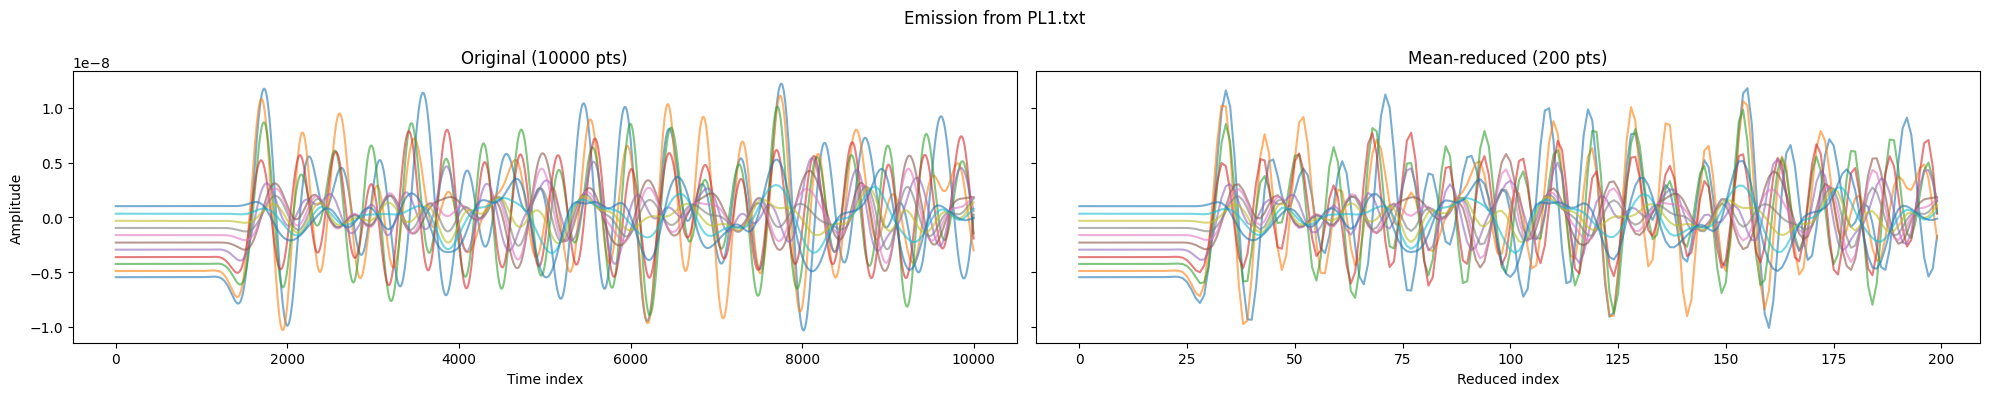

In [3]:
N = 50  # CHANGE REDUCTION PARAMETER (20 - 50 is a good value)

# 1) Pick sample “00” and its first PL*.txt file
sample0 = Path(WAVES_DIR) / "00"
file0 = sorted(sample0.glob("PL*.txt"))[0]

# 2) Load original waveforms (11 × 10000)
orig = load_emission_waveforms(file0, modo="", n=0)  # no reduction
# 3) Load reduced waveforms (11 × 200) via windowed mean
reduced = load_emission_waveforms(file0, modo="mean", n=N) 

# 4) Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), sharey=True)

# Left: original
for i in range(orig.shape[0]):
    ax1.plot(orig[i].cpu().numpy(), alpha=0.6)
ax1.set_title(f"Original ({orig.shape[1]} pts)")
ax1.set_xlabel("Time index")
ax1.set_ylabel("Amplitude")

# Right: reduced
for i in range(reduced.shape[0]):
    ax2.plot(reduced[i].cpu().numpy(), alpha=0.6)
ax2.set_title(f"Mean‐reduced ({reduced.shape[1]} pts)")
ax2.set_xlabel("Reduced index")

plt.suptitle(f"Emission from {file0.name}")
plt.tight_layout()
plt.show()

## Sample‐wise Concatenation + Full Loading

- `load_sample_waveforms`: one sample → 66×L tensor  
- `load_all_waveforms`: all samples concatenated → (6600, L)  
- `load_waveforms_by_sample`: stacked by sample → (100, 66, L)

We reduce the waves to L = 100 points and then concatenate them these three ways. It takes about a minute.

In [4]:
# Cell 8: Test ondas_probeta, leer_ondas, leer_probetas
pb = load_sample_waveforms(Path(WAVES_DIR)/"00", modo="max", n=100)
print("load_sample_waveforms shape:", pb.shape)  # (66,100)

all_w = load_all_waveforms(Path(WAVES_DIR), reduccion="max", n=100)
print("load_all_waveforms:", all_w.shape)  # (6600,100)

stacked = load_waveforms_by_sample(Path(WAVES_DIR), reduccion="max", n=100)
print("load_waveforms_by_sample:", stacked.shape)  # (100,66,100)


load_sample_waveforms shape: torch.Size([66, 100])
load_all_waveforms: torch.Size([6600, 100])
load_waveforms_by_sample: torch.Size([100, 66, 100])
